In [2]:
###CropRow Detection Using Binary ExGI image 
###Ranjan Sapkota, MS project 

###Importing Libraries
import os                          #creating and removing directory
import numpy as np                 #imports all numpy modules
from PIL import Image              #python imaging library for interpreting python with image editing capability
import rasterio                    #All GDAL and geolocation processing
from matplotlib import pyplot as plt   #graph plotting
import cv2                          #Computer Vision Library and Image Processing
from skimage.feature import hessian_matrix, hessian_matrix_eigvals    #image processing operator in computer vision, describes local curvatures of function
from scipy.signal import find_peaks #find peaks inside a signal based on peak properties. 

In [3]:
# Read .tif file via rasterio

path = 'RanjanDirectory/CREC_Corn_Sony40MP_350ft_06242020_ExGr_AOI_05.tif'
dataset = rasterio.open(path) # it contains raster data and geospatial information
field_image = dataset.read(1) # get raster data (only image)

In [4]:
# We want result image with only lines, so we prepare zero-like array

result_image = np.zeros((field_image.shape[0],field_image.shape[1]),
                        dtype=np.uint8) # creates array with zeros and shape of field_image

In [5]:
# Because lines are horizontal - we can make a projection of them on Y axis
# We calculate Y coordinates of the lines via sum and then find peaks on Y projection

def get_lines_coordinates(cropped_image):
    sum_y = np.sum(cropped_image,axis=1) # For each row in image summarizes all values into single value
    peaks = find_peaks(sum_y, distance=90, prominence=10) # Finds local maximums in array of Y-summed values
    return peaks

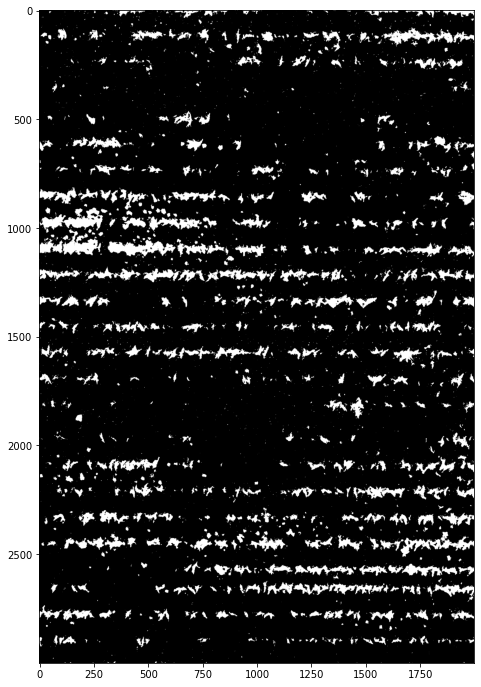

In [12]:
# For example, this is how left corner of field image looks like (first 3000x2000 pixels of whole image)
cropped_image = field_image[:3000,:2000]
plt.figure(figsize=(12,12))
plt.imshow(cropped_image,cmap='gray')
plt.show()

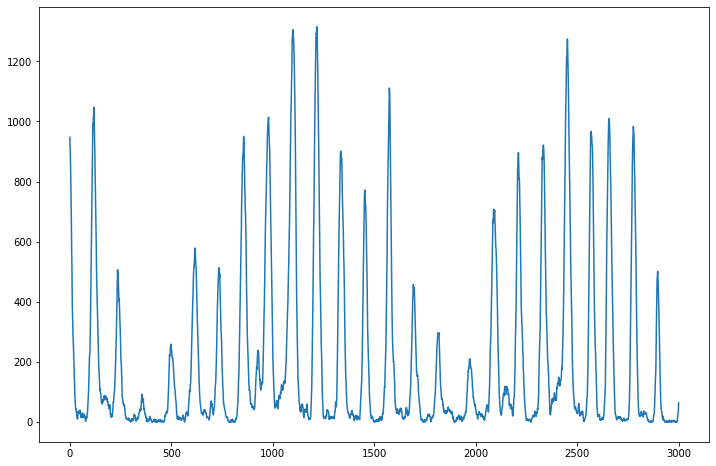

In [22]:
# When we sum pixels by vertical axis (rows of 1x2000 pixels), we get array sum_y
plt.figure(figsize=(12,8))
sum_y = np.sum(cropped_image,axis=1) # Projection on Y axis
plt.plot(sum_y) # It looks like this, each peak represents local maximum -> corn line
plt.show()

In [23]:
peaks = find_peaks(sum_y, distance=90, prominence=10) # Finds local maximums in array of Y-summed values
peaks[0] # Y coordinates of each local maximum (y coordinate of corn line)

array([ 118,  235,  355,  497,  617,  735,  856,  979, 1099, 1216, 1335,
       1453, 1574, 1692, 1814, 1969, 2088, 2210, 2332, 2451, 2655, 2776,
       2896])

In [24]:
# We split whole image into many (y_len,x_len) regions

x_len = 3000 # Can be set manually, here, it is the best lenght
y_len = 2000
for j in range(int(np.ceil(field_image.shape[0]/y_len))): # For each j-th region on Y axis
    for k in range(int(np.ceil(field_image.shape[1]/x_len))): # For each k-th region on X axis
        cropped_image = field_image[j*y_len:(j+1)*y_len,k*x_len:(k+1)*x_len] # Choose area of (y_len,x_len) pixels
        cropped_lines = np.zeros(cropped_image.shape,dtype=np.uint8) # Prepare array of zeros and shape (y_len,x_len)
        peaks = get_lines_coordinates(cropped_image) # Get peaks for this region
        for peak in peaks[0]:
            cropped_lines[peak-3:peak+3,:] = 255 # Draw white line on peaks coordinates
        result_image[j*y_len:(j+1)*y_len,k*x_len:(k+1)*x_len] = cropped_lines # Draw these line onto result image

In [25]:
dataset.transform # Geospatial information

Affine(0.006330000000000423, 0.0, 490264.32875,
       0.0, -0.0063300000000043365, 5262398.078860001)

In [26]:
# Saving result image of lines as .tif file with geospatial information
new_dataset = rasterio.open(
    'result_lines.tif', # output path
    'w', # writing data
    driver=dataset.driver, # information from ArcGis
    height=dataset.height, # image height
    width=dataset.width, # image width
    count=1,
    dtype=result_image.dtype, # data type of saved image
    crs=dataset.crs, # type of coordinate system
    transform=dataset.transform # geospatial data
)

new_dataset.write(result_image, 1) # write
new_dataset.close()    #save the new dataset as a final product